The Pandeia engine relies on a library of precomputed PSFs that are sparsely sampled across the coronagraphic field of view. This sparse sampling will often be insufficient for accurately capturing PSF variations arising from small offsets.

Pandeia-Coronagraphy gives the option (```engine.on_the_fly_PSFs```) to circumvent the use of this precomputed library and force recomputing each PSF on the fly in WebbPSF. This notebook demonstrates this option.


(This notebook could really be simplified. The ```engine.on_the_fly_PSFs``` toggle is the only important part. Rather than compute the contrast, maybe do a quick calculation to demonstrate the difference between the precomputed and WebbPSF PSF.)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pandeia_coronagraphy import scene, analysis, transformations, engine

from copy import deepcopy
import numpy as np

# Setting up the Scene

We'll simply duplicate the scene definitions from the nircam_contrast notebook.

(0, 1.5)

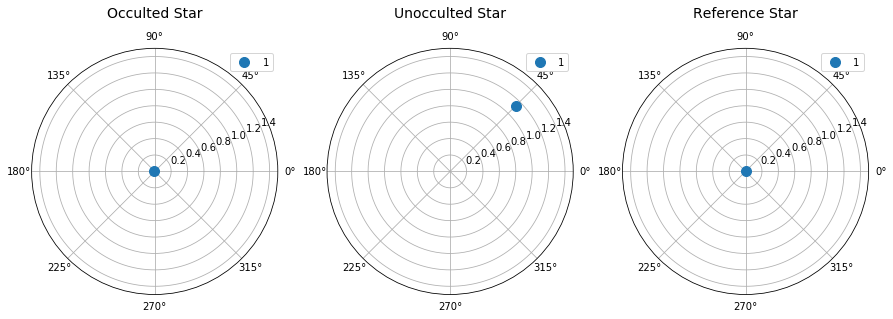

In [2]:

# Target Star
occulted = engine.load_calculation('../templates/nircam_coronagraphy_template.json')
#set instrument parameters
occulted['configuration']['instrument']['aperture'] = 'mask210r'
occulted['configuration']['instrument']['filter'] = 'f210m'
occulted['configuration']['detector']['ngroup'] = 20
#set star properties
occstar = occulted['scene'][0]
occstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
occstar['spectrum']['normalization']['norm_flux'] = 10.
occstar['spectrum']['sed']['key'] = 'a5v'
# and a unique TA error
errx, erry = scene.get_ta_error()
scene.offset_scene(occulted['scene'],errx,erry)

# Unocculted Star
unocculted = deepcopy(occulted)
#apply an offset
unocculted['scene'][0]['position']['x_offset'] = 0.8 #arcsec
unocculted['scene'][0]['position']['y_offset'] = 0.8 #arcsec
unocculted['calculation']['effects']['saturation'] = False #disable saturation

# Reference Star
reference = deepcopy(occulted)
# we adopt a brighter but spectrally-mismatched reference
refstar = reference['scene'][0]
refstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
refstar['spectrum']['normalization']['norm_flux'] = 9.
refstar['spectrum']['sed']['key'] = 'a3v'
refstar['position']['x_offset'] = 0. #reset the offset to avoid stacking TA errors
refstar['position']['y_offset'] = 0.
# and a unique TA error
errx_ref, erry_ref = scene.get_ta_error()
scene.offset_scene(reference['scene'],errx_ref,erry_ref)


plt.figure(figsize=(15,5))
plt.subplot(131,polar=True)
scene.plot_scene(occulted['scene'],'Occulted Star',newfig=False)
ax = plt.gca()
ax.set_rlim(0,1.5)
plt.subplot(132,polar=True)
scene.plot_scene(unocculted['scene'],'Unocculted Star',newfig=False)
ax = plt.gca()
ax.set_rlim(0,1.5)
plt.subplot(133,polar=True)
scene.plot_scene(reference['scene'],'Reference Star',newfig=False)
ax = plt.gca()
ax.set_rlim(0,1.5)

# Contrast with WebbPSF on-the-fly PSFs

Enable on-the-fly PSFs and run the engine.

In [3]:
engine.on_the_fly_PSFs = True
engine.wave_sampling = 20
occ_results2, unocc_results2, ref_results2 = engine.calculate_batch([occulted,unocculted,reference])

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


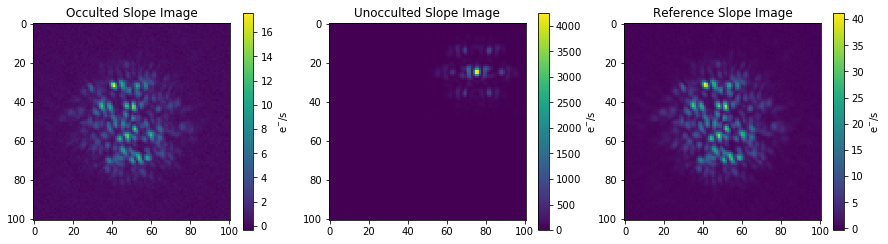

In [4]:
occ_slope = occ_results2['2d']['detector']
unocc_slope = unocc_results2['2d']['detector']
ref_slope = ref_results2['2d']['detector']

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(occ_slope)
plt.title('Occulted Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(unocc_slope)
plt.title('Unocculted Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(ref_slope)
plt.title('Reference Slope Image')
plt.colorbar().set_label('e$^{-}$/s')

Compute the contrast. (Everything that follows in this section is a duplicate of code in the nircam_contrast notebook.)

In [5]:
#register the reference to the occulted target for subtraction
centered_occ = occ_slope - np.nanmean(occ_slope)
centered_ref = ref_slope - np.nanmean(ref_slope)
reg_ref = analysis.register_to_target(centered_ref,centered_occ)
ref_sub = centered_occ - reg_ref

In [6]:
# convolve the unocculted image with an aperture and pick out the max 
# as the normalization constant
from scipy.signal import fftconvolve
kernel = np.array([[0,0,1,0,0], #simple aperture
                   [0,1,1,1,0],
                   [1,1,1,1,1],
                   [0,1,1,1,0],
                   [0,0,1,0,0]]).astype(float)
unocc_aperture = fftconvolve(unocc_slope,kernel)
norm = np.max(unocc_aperture)

#convolve reference-subtract and raw frames with the aperture as well
refsub_aperture = fftconvolve(ref_sub,kernel)
occ_aperture = fftconvolve(centered_occ,kernel)

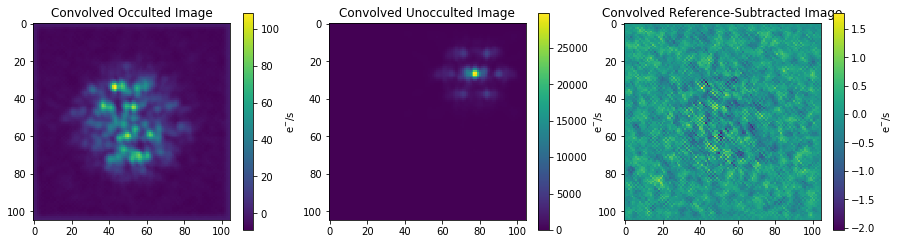

In [7]:
#plot
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(occ_aperture)
plt.title('Convolved Occulted Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(unocc_aperture)
plt.title('Convolved Unocculted Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(refsub_aperture)
plt.title('Convolved Reference-Subtracted Image')
plt.colorbar().set_label('e$^{-}$/s')

In [8]:
# compute radial distance from center (in pixels)
indices = np.indices(occ_slope.shape)
center = np.array(occ_slope.shape) / 2.
radial = np.sqrt( (indices[0] - center[0])**2 + (indices[1] - center[1])**2 )
# compute 20 annuli (uniform in radius)
radial_bins = np.linspace(0,np.max(radial),num=20)
annuli_inds = np.digitize(radial,radial_bins)

# take std dev of raw and reference-subtracted images in each annulus and normalize by unocculted max
raw_contrast = np.array([np.std(occ_aperture[annuli_inds == a]) for a in np.unique(annuli_inds)]) / norm
refsub_contrast = np.array([np.std(refsub_aperture[annuli_inds == a]) for a in np.unique(annuli_inds)]) / norm

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 105 but corresponding boolean dimension is 101
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 105 but corresponding boolean dimension is 101


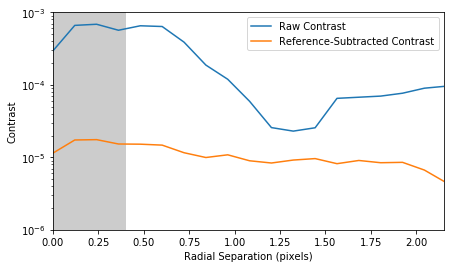

In [9]:
pix_scale = 0.032 # see https://jwst-docs.stsci.edu/display/JTI/NIRCam+Imaging
mask_radii = 0.4 # see https://jwst-docs.stsci.edu/display/JTI/NIRCam+Coronagraphic+Imaging

plt.figure(figsize=(7,4))
plt.semilogy(radial_bins * pix_scale,raw_contrast,label='Raw Contrast')
plt.semilogy(radial_bins * pix_scale,refsub_contrast,label='Reference-Subtracted Contrast')
plt.fill_between([0,mask_radii],1e-6,1e-3,color='k',alpha=0.2,lw=0)
plt.xlabel('Radial Separation (pixels)')
plt.ylabel('Contrast')
plt.xlim(0,2.15)
plt.ylim(1e-6,1e-3)
plt.legend(loc='upper right')